In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy.ndimage import gaussian_filter
from scipy.stats import beta

In [17]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))

base_dir = os.path.join(project_root, 'data', 'soict-hackathon-2024_dataset')
images_dir = os.path.join(base_dir, "images")
labels_dir = os.path.join(base_dir, "labels")
train_images_dir = os.path.join(images_dir, "train")
train_labels_dir = os.path.join(labels_dir, "train")
valid_images_dir = os.path.join(images_dir, "val")
valid_labels_dir = os.path.join(labels_dir, "val")

# Khám phá dataset

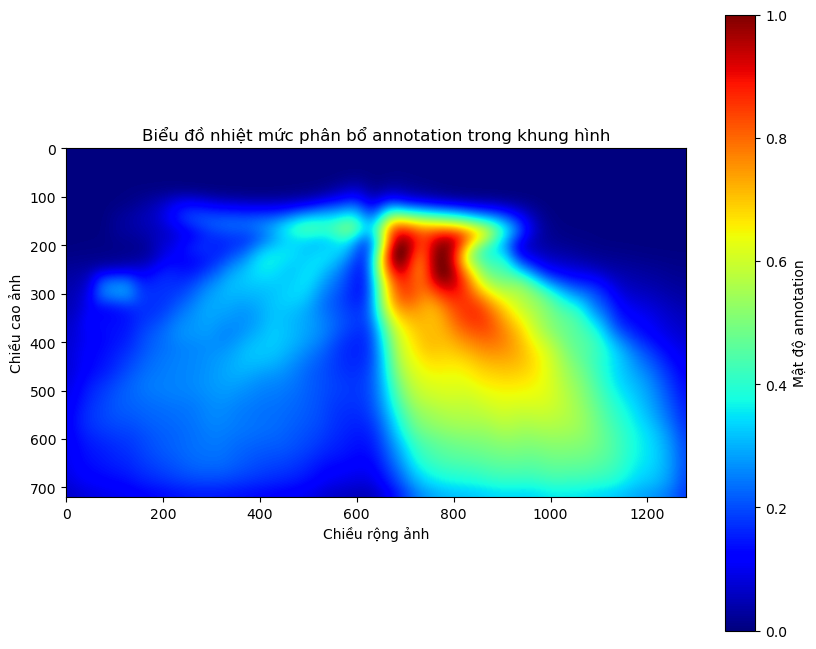

In [18]:
image_width, image_height = 1280, 720

# Khởi tạo ma trận heatmap
heatmap_data = np.zeros((image_height, image_width))

# Hàm để cập nhật heatmap từ một thư mục nhãn
def update_heatmap_from_labels(labels_dir):
    global heatmap_data
    # Duyệt qua tất cả các file nhãn trong thư mục
    for filename in os.listdir(labels_dir):
        if filename.endswith('.txt'):
            file_path = os.path.join(labels_dir, filename)
            with open(file_path, 'r') as f:
                annotations = f.readlines()
                for annotation in annotations:
                    # Đọc thông tin từ nhãn
                    class_id, x_center_norm, y_center_norm, width_norm, height_norm = map(float, annotation.strip().split())
                    # Chuyển tọa độ từ YOLO format về tọa độ pixel
                    x_center = x_center_norm * image_width
                    y_center = y_center_norm * image_height
                    width = width_norm * image_width
                    height = height_norm * image_height
                    # Tính toán tọa độ góc của bounding box
                    x_min = int(x_center - width / 2)
                    x_max = int(x_center + width / 2)
                    y_min = int(y_center - height / 2)
                    y_max = int(y_center + height / 2)
                    # Đảm bảo tọa độ nằm trong kích thước ảnh
                    x_min = max(0, x_min)
                    x_max = min(image_width - 1, x_max)
                    y_min = max(0, y_min)
                    y_max = min(image_height - 1, y_max)
                    # Tăng giá trị trong vùng bounding box
                    heatmap_data[y_min:y_max+1, x_min:x_max+1] += 1

# Cập nhật heatmap từ tập train và val
update_heatmap_from_labels(train_labels_dir)
update_heatmap_from_labels(valid_labels_dir)

# Làm mịn heatmap_data bằng Gaussian filter
heatmap_smoothed = gaussian_filter(heatmap_data, sigma=15)

# Chuẩn hóa heatmap_data về khoảng [0, 1]
heatmap_normalized = heatmap_smoothed / np.max(heatmap_smoothed)

# Hiển thị heatmap để trực quan
plt.figure(figsize=(10, 8))
plt.imshow(heatmap_normalized, cmap='jet')
plt.colorbar(label='Mật độ annotation')
plt.xlabel('Chiều rộng ảnh')
plt.ylabel('Chiều cao ảnh')
plt.title('Biểu đồ nhiệt mức phân bổ annotation trong khung hình')
plt.show()

In [19]:
# Chia ảnh thành lưới ô vuông
grid_size = 8
grid_height = image_height // grid_size
grid_width = image_width // grid_size

# Tính tổng giá trị heatmap trong mỗi ô
crop_candidates = []
for i in range(grid_size):
    for j in range(grid_size):
        x_start = j * grid_width
        y_start = i * grid_height
        x_end = x_start + grid_width
        y_end = y_start + grid_height
        cell_heat = heatmap_normalized[y_start:y_end, x_start:x_end].sum()
        crop_candidates.append({
            'x_start': x_start,
            'y_start': y_start,
            'x_end': x_end,
            'y_end': y_end,
            'heat': cell_heat
        })

# Sắp xếp các ô theo giá trị heat
crop_candidates.sort(key=lambda x: x['heat'], reverse=True)

top_n = 5
selected_crops = crop_candidates[:top_n]

# Xuất thông số crop
print("Các thông số Crop đề xuất:")
for idx, crop in enumerate(selected_crops):
    print(f"Crop {idx + 1}: (x_start: {crop['x_start']}, y_start: {crop['y_start']}, width: {grid_width}, height: {grid_height})")

Các thông số Crop đề xuất:
Crop 1: (x_start: 640, y_start: 180, width: 160, height: 90)
Crop 2: (x_start: 640, y_start: 270, width: 160, height: 90)
Crop 3: (x_start: 800, y_start: 360, width: 160, height: 90)
Crop 4: (x_start: 800, y_start: 270, width: 160, height: 90)
Crop 5: (x_start: 800, y_start: 450, width: 160, height: 90)


# Điều chỉnh màu dữ liệu

In [20]:
# Hàm để tính toán các thống kê của hsv_h, hsv_s, hsv_v cho một hình ảnh
def calculate_hsv_statistics(image):
    hsv_image = image.convert('HSV')
    hsv_array = np.array(hsv_image, dtype=np.float32) / 255.0  # Chuẩn hóa về [0, 1]

    h_channel = hsv_array[:, :, 0]
    s_channel = hsv_array[:, :, 1]
    v_channel = hsv_array[:, :, 2]

    # Tính các thống kê
    h_mean = h_channel.mean()
    h_std = h_channel.std()
    h_min = h_channel.min()
    h_max = h_channel.max()

    s_mean = s_channel.mean()
    s_std = s_channel.std()
    s_min = s_channel.min()
    s_max = s_channel.max()

    v_mean = v_channel.mean()
    v_std = v_channel.std()
    v_min = v_channel.min()
    v_max = v_channel.max()

    return (h_mean, h_std, h_min, h_max), (s_mean, s_std, s_min, s_max), (v_mean, v_std, v_min, v_max)

In [21]:
# Tính toán thống kê cho tập hình ảnh
def compute_hsv_statistics_for_dataset(image_dirs):
    h_values = []
    s_values = []
    v_values = []

    for image_dir in image_dirs:
        image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for image_file in image_files:
            image_path = os.path.join(image_dir, image_file)
            image = Image.open(image_path).convert('RGB')

            (h_mean, h_std, h_min, h_max), (s_mean, s_std, s_min, s_max), (v_mean, v_std, v_min, v_max) = calculate_hsv_statistics(image)

            h_values.append((h_mean, h_std, h_min, h_max))
            s_values.append((s_mean, s_std, s_min, s_max))
            v_values.append((v_mean, v_std, v_min, v_max))

    # Chuyển đổi danh sách thành mảng numpy để dễ tính toán
    h_stats = np.array(h_values)
    s_stats = np.array(s_values)
    v_stats = np.array(v_values)

    # Tính thống kê chung cho toàn bộ tập dữ liệu
    h_overall_mean = h_stats[:, 0].mean()
    h_overall_std = h_stats[:, 0].std()
    h_overall_min = h_stats[:, 2].min()
    h_overall_max = h_stats[:, 3].max()

    s_overall_mean = s_stats[:, 0].mean()
    s_overall_std = s_stats[:, 0].std()
    s_overall_min = s_stats[:, 2].min()
    s_overall_max = s_stats[:, 3].max()

    v_overall_mean = v_stats[:, 0].mean()
    v_overall_std = v_stats[:, 0].std()
    v_overall_min = v_stats[:, 2].min()
    v_overall_max = v_stats[:, 3].max()

    return {
        'h': {'mean': h_overall_mean, 'std': h_overall_std, 'min': h_overall_min, 'max': h_overall_max},
        's': {'mean': s_overall_mean, 'std': s_overall_std, 'min': s_overall_min, 'max': s_overall_max},
        'v': {'mean': v_overall_mean, 'std': v_overall_std, 'min': v_overall_min, 'max': v_overall_max},
    }

In [22]:
# Hàm để tính toán các thông số tối ưu cho hsv_h, hsv_s, hsv_v
def compute_optimal_hsv_parameters(stats):

    # Tính toán phạm vi cho hue (hsv_h)
    hsv_h = min(stats['h']['std'] * 2, 0.5)

    # Tính toán phạm vi cho saturation (hsv_s)
    hsv_s = min(stats['s']['std'] * 2, 0.9)

    # Tính toán phạm vi cho brightness/value (hsv_v)
    hsv_v = min(stats['v']['std'] * 2, 0.9)

    return hsv_h, hsv_s, hsv_v

In [23]:
# Tính toán thống kê cho tập train và val
stats = compute_hsv_statistics_for_dataset([train_images_dir, valid_images_dir])

# In ra các thống kê
print("Thống kê HSV cho toàn bộ tập dữ liệu:")
print(f"Hue - Mean: {stats['h']['mean']:.4f}, Std: {stats['h']['std']:.4f}, Min: {stats['h']['min']:.4f}, Max: {stats['h']['max']:.4f}")
print(f"Saturation - Mean: {stats['s']['mean']:.4f}, Std: {stats['s']['std']:.4f}, Min: {stats['s']['min']:.4f}, Max: {stats['s']['max']:.4f}")
print(f"Value - Mean: {stats['v']['mean']:.4f}, Std: {stats['v']['std']:.4f}, Min: {stats['v']['min']:.4f}, Max: {stats['v']['max']:.4f}")

# Tính toán các thông số tối ưu cho hsv_h, hsv_s, hsv_v
optimal_hsv_h, optimal_hsv_s, optimal_hsv_v = compute_optimal_hsv_parameters(stats)

# In ra các thông số tối ưu
print("\nCác thông số tối ưu cho tăng cường dữ liệu:")
print(f"hsv_h (Hue adjustment factor): {optimal_hsv_h:.4f}")
print(f"hsv_s (Saturation adjustment factor): {optimal_hsv_s:.4f}")
print(f"hsv_v (Brightness adjustment factor): {optimal_hsv_v:.4f}")

Thống kê HSV cho toàn bộ tập dữ liệu:
Hue - Mean: 0.4445, Std: 0.0772, Min: 0.0000, Max: 0.9961
Saturation - Mean: 0.2922, Std: 0.1607, Min: 0.0000, Max: 1.0000
Value - Mean: 0.3893, Std: 0.0848, Min: 0.0000, Max: 1.0000

Các thông số tối ưu cho tăng cường dữ liệu:
hsv_h (Hue adjustment factor): 0.1544
hsv_s (Saturation adjustment factor): 0.3215
hsv_v (Brightness adjustment factor): 0.1697


# Tính toán các thông số erasing, crop-fraction

In [24]:
# Xác định kích thước ảnh 
image_width, image_height = 1280, 720  

# Khởi tạo ma trận heatmap
heatmap_data = np.zeros((image_height, image_width))

# Hàm để cập nhật heatmap từ một thư mục nhãn
def update_heatmap_from_labels(labels_dir):
    global heatmap_data
    # Duyệt qua tất cả các file nhãn trong thư mục
    for filename in os.listdir(labels_dir):
        if filename.endswith('.txt'):
            file_path = os.path.join(labels_dir, filename)
            with open(file_path, 'r') as f:
                annotations = f.readlines()
                for annotation in annotations:
                    # Đọc thông tin từ nhãn
                    class_id, x_center_norm, y_center_norm, width_norm, height_norm = map(float, annotation.strip().split())
                    # Chuyển tọa độ từ YOLO format về tọa độ pixel
                    x_center = int(x_center_norm * image_width)
                    y_center = int(y_center_norm * image_height)
                    width = int(width_norm * image_width)
                    height = int(height_norm * image_height)
                    # Tính toán tọa độ góc của bounding box
                    x_min = x_center - width // 2
                    x_max = x_center + width // 2
                    y_min = y_center - height // 2
                    y_max = y_center + height // 2
                    # Đảm bảo tọa độ nằm trong kích thước ảnh
                    x_min = max(0, x_min)
                    x_max = min(image_width - 1, x_max)
                    y_min = max(0, y_min)
                    y_max = min(image_height - 1, y_max)
                    # Tăng giá trị trong vùng bounding box
                    heatmap_data[y_min:y_max+1, x_min:x_max+1] += 1

# Cập nhật heatmap từ tập train và val
update_heatmap_from_labels(train_labels_dir)
update_heatmap_from_labels(valid_labels_dir)

# Làm mịn heatmap_data bằng Gaussian filter
heatmap_smoothed = gaussian_filter(heatmap_data, sigma=15)

# Chuẩn hóa heatmap_data về khoảng [0, 1]
heatmap_normalized = heatmap_smoothed / np.max(heatmap_smoothed)

In [25]:
# Tính toán thông số tối ưu cho erasing
def compute_optimal_erasing(heatmap):
    threshold = 0.2
    low_annotation_area = np.sum(heatmap < threshold)
    total_area = heatmap.size
    erasing_ratio = low_annotation_area / total_area
    return erasing_ratio

# Tính toán thông số tối ưu cho crop_fraction
def compute_optimal_crop_fraction(heatmap):
    threshold = 0.5
    high_annotation_area = np.sum(heatmap > threshold)
    total_area = heatmap.size
    crop_fraction = high_annotation_area / total_area
    return crop_fraction

# Tính toán các thông số tối ưu
optimal_erasing = compute_optimal_erasing(heatmap_normalized)
optimal_crop_fraction = compute_optimal_crop_fraction(heatmap_normalized)

# In ra các thông số tối ưu
print("Thông số tối ưu cho erasing:", optimal_erasing)
print("Thông số tối ưu cho crop_fraction:", optimal_crop_fraction)

Thông số tối ưu cho erasing: 0.46439453125
Thông số tối ưu cho crop_fraction: 0.1610134548611111


# Tính toán các thông số translate, scale, shear


In [44]:
# Xác định kích thước ảnh
image_width, image_height = 1280, 720 

# Hàm để tính toán thông số tối ưu cho translate
def compute_optimal_translate(image_dirs):
    translate_x_ratios = []
    translate_y_ratios = []
    for image_dir in image_dirs:
        image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for image_file in image_files:
            image_path = os.path.join(image_dir, image_file)
            image = Image.open(image_path).convert('RGB')
            width, height = image.size
            # Tính toán tỷ lệ dịch chuyển tối đa theo chiều rộng và chiều cao
            translate_x = np.random.uniform(0.0, 1.0) * width
            translate_y = np.random.uniform(0.0, 1.0) * height
            translate_x_ratios.append(translate_x / width)
            translate_y_ratios.append(translate_y / height)
    optimal_translate_x = np.mean(translate_x_ratios)
    optimal_translate_y = np.mean(translate_y_ratios)
    return optimal_translate_x, optimal_translate_y

In [45]:
# Hàm để tính toán thông số tối ưu cho scale
def compute_optimal_scale(image_dirs):
    scales = []
    for image_dir in image_dirs:
        image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for image_file in image_files:
            image_path = os.path.join(image_dir, image_file)
            image = Image.open(image_path).convert('RGB')
            width, height = image.size
            scale = np.random.uniform(0.0, 1.0)
            scales.append(scale)
    optimal_scale = np.mean(scales)
    return optimal_scale

In [46]:
# Hàm để tính toán thông số tối ưu cho shear
def compute_optimal_shear(image_dirs):
    shears = []
    for image_dir in image_dirs:
        image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for image_file in image_files:
            image_path = os.path.join(image_dir, image_file)
            image = Image.open(image_path).convert('RGB')
            shear = np.random.uniform(-180, 180)
            shears.append(shear)
    optimal_shear = np.mean(shears)
    return optimal_shear

In [47]:
# Gộp cả hai tập dữ liệu train và val
all_image_dirs = [train_images_dir, valid_images_dir]

# Tính toán các thông số tối ưu
optimal_translate = compute_optimal_translate(all_image_dirs)
optimal_scale = compute_optimal_scale(all_image_dirs)
optimal_shear = compute_optimal_shear(all_image_dirs)

# In ra các thông số tối ưu
print("Thông số tối ưu cho translate:", optimal_translate)
print("Thông số tối ưu cho scale:", optimal_scale)
print("Thông số tối ưu cho shear:", optimal_shear)

Thông số tối ưu cho translate: (0.49927392853130587, 0.5050595601567148)
Thông số tối ưu cho scale: 0.49635050614388015
Thông số tối ưu cho shear: 1.9336689209738718


# Tính toán các thông số mosaic, mixup

In [30]:
# Hàm để tính toán thông số tối ưu cho mosaic
def compute_optimal_mosaic(image_dirs):
    mosaic_ratios = []
    for image_dir in image_dirs:
        image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for _ in range(len(image_files) // 4):  # Chọn ngẫu nhiên bốn ảnh từ tập dữ liệu
            img1, img2, img3, img4 = np.random.choice(image_files, 4, replace=False)
            # Đọc các ảnh
            img1 = Image.open(os.path.join(image_dir, img1)).convert('RGB')
            img2 = Image.open(os.path.join(image_dir, img2)).convert('RGB')
            img3 = Image.open(os.path.join(image_dir, img3)).convert('RGB')
            img4 = Image.open(os.path.join(image_dir, img4)).convert('RGB')
            # Tính toán tỷ lệ ghép của các ảnh
            h, w = img1.size
            mosaic_ratio = (h * w) / (4 * h * w)  # Tỷ lệ ghép của các ảnh
            mosaic_ratios.append(mosaic_ratio)
    optimal_mosaic = np.mean(mosaic_ratios)
    return optimal_mosaic

In [31]:
# Hàm để tính toán thông số tối ưu cho mixup
def compute_optimal_mixup(image_dirs, alpha=0.2):
    mixup_ratios = []
    for image_dir in image_dirs:
        image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for _ in range(len(image_files) // 2):  # Chọn ngẫu nhiên hai ảnh từ tập dữ liệu
            img1, img2 = np.random.choice(image_files, 2, replace=False)
            # Đọc các ảnh
            img1 = Image.open(os.path.join(image_dir, img1)).convert('RGB')
            img2 = Image.open(os.path.join(image_dir, img2)).convert('RGB')
            # Tạo trọng số ngẫu nhiên từ phân phối Beta
            lam = beta.rvs(alpha, alpha)
            mixup_ratios.append(lam)
    optimal_mixup = np.mean(mixup_ratios)
    return optimal_mixup

In [32]:
# Gộp cả hai tập dữ liệu train và val
all_image_dirs = [train_images_dir, valid_images_dir]

# Tính toán các thông số tối ưu
optimal_mosaic = compute_optimal_mosaic(all_image_dirs)
optimal_mixup = compute_optimal_mixup(all_image_dirs)

# In ra các thông số tối ưu
print("Thông số tối ưu cho mosaic:", optimal_mosaic)
print("Thông số tối ưu cho mixup:", optimal_mixup)

Thông số tối ưu cho mosaic: 0.25
Thông số tối ưu cho mixup: 0.4992406213380667


# Lưu kết quả

In [48]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
output_stats_file = os.path.join(project_root, 'runs', 'augmentation-hyperparameter.txt')

# Đọc nội dung hiện tại của tệp
if os.path.exists(output_stats_file):
    with open(output_stats_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
else:
    lines = []
    
# Cập nhật hoặc thêm các thông số tối ưu
with open(output_stats_file, 'w', encoding='utf-8') as f:
    updated = False
    updated_erasing = False
    updated_crop_fraction = False
    updated_translate = False
    updated_scale = False
    updated_shear = False
    updated_mosaic = False
    updated_mixup = False
    for line in lines:
        if line.startswith("hsv_h"):
            f.write(f"hsv_h {optimal_hsv_h:.4f}\n")
            updated = True
        elif line.startswith("hsv_s"):
            f.write(f"hsv_s {optimal_hsv_s:.4f}\n")
            updated = True
        elif line.startswith("hsv_v"):
            f.write(f"hsv_v {optimal_hsv_v:.4f}\n")
            updated = True
        elif line.startswith("erasing"):
            f.write(f"erasing {optimal_erasing:.4f}\n")
            updated_erasing = True
        elif line.startswith("crop-fraction"):
            f.write(f"crop-fraction {optimal_crop_fraction:.4f}\n")
            updated_crop_fraction = True
        elif line.startswith("translate"):
            f.write(f"translate {optimal_translate}\n")
            updated_translate = True
        elif line.startswith("scale"):
            f.write(f"scale {optimal_scale}\n")
            updated_scale = True
        elif line.startswith("shear"):
            f.write(f"shear {optimal_shear}\n")
            updated_shear = True
        elif line.startswith("mosaic"):
            f.write(f"mosaic {optimal_mosaic}\n")
            updated_mosaic = True
        elif line.startswith("mixup"):
            f.write(f"mixup {optimal_mixup}\n")
            updated_mixup = True
        else:
            f.write(line)
    if not updated:
        f.write(f"hsv_h {optimal_hsv_h:.4f}\n")
        f.write(f"hsv_s {optimal_hsv_s:.4f}\n")
        f.write(f"hsv_v {optimal_hsv_v:.4f}\n")
    if not updated_erasing:
        f.write(f"erasing {optimal_erasing:.4f}\n")
    if not updated_crop_fraction:
        f.write(f"crop-fraction {optimal_crop_fraction:.4f}\n")
    if not updated_translate:
        f.write(f"translate {optimal_translate}\n")
    if not updated_scale:
        f.write(f"scale {optimal_scale}\n")
    if not updated_shear:
        f.write(f"shear {optimal_shear}\n")
    if not updated_mosaic:
        f.write(f"mosaic {optimal_mosaic}\n")
    if not updated_mixup:
        f.write(f"mixup {optimal_mixup}\n")

print(f"\nĐã lưu kết quả các thông số tối ưu vào tệp '{output_stats_file}'")


Đã lưu kết quả các thông số tối ưu vào tệp 'd:\Task\VehicleDetection\runs\augmentation-hyperparameter.txt'
